In [1]:
import numpy as np
from Bio.Seq import Seq
# import itertools
import torch
import pandas as pd
import sys
sys.path.append("scripts/")
from ixnos import iXnos, encode
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("src/")
from src import legend_kwargs

def get_inputs(codons : list):
    # Given a list of codons, get an input vector for iXnos
    nts = "".join(codons)
    codon_vector = np.concatenate([encode(i, iXnos.get_codon_to_id()) for i in codons])
    nt_vector = np.concatenate([encode(i, iXnos.get_nt_to_id()) for i in nts])
    input_vector = np.concatenate([codon_vector, nt_vector])
    input_vector = torch.from_numpy(input_vector).to(torch.float32)
    return input_vector

def predict_elongation(seq, model, min_cod=-5, max_cod=4):
    """Given a sequence and an iXnos model, predict the sum of
    scaled counts at each codon index.

    Args:
        seq (str): Amino acid sequence of transcript of interest.
        model (iXnos model): iXnos model to use
        min_cod (int, optional): Minimum index of codons used in iXnos model. Defaults to -5.
        max_cod (int, optional): Maximum index of codons used in iXnos model. Defaults to 4.

    Returns:
        int: Sum of scaled counts; proxy for predicted elongation time
    """    
    seq = seq.upper()
    # I train iXnos on DNA sequences, so need to convert U to T
    if "U" in seq:
        seq = seq.replace("U", "T")
    # Add "NNN" codons to beginning and end of sequence in order to pass 
    # first and last few codons through iXnos
    seq = "".join(["NNN" for i in range(0 - min_cod)]) \
        + seq + "".join(["NNN" for i in range(max_cod)])
    # Predict scaled counts across all codons
    codons = [seq[i:i+3] for i in range(0, len(seq), 3)]
    overall_count = 0
    for i in range(0 - min_cod, len(codons) - max_cod):
        input_vector = get_inputs(codons[i + min_cod:i + max_cod + 1])
        overall_count += model(input_vector).item()
    return overall_count

In [2]:
ansari_n5p4 = iXnos(n_codons=10)
ansari_n5p4.load_state_dict(
    torch.load("processed-data/thp1_v2/models/ixnos_n5p4_full.pth"))
ansari_n3p2 = iXnos(n_codons=6)
ansari_n3p2.load_state_dict(
    torch.load("processed-data/thp1_v2/models/ixnos_n3p2_full.pth"))
iwasaki_n5p4 = iXnos(n_codons=10)
iwasaki_n5p4.load_state_dict(
    torch.load("models/ixnos_retrained.pth"))
iwasaki_n3p2 = iXnos(n_codons=6)
iwasaki_n3p2.load_state_dict(
    torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth"))

df = pd.read_csv("processed-data/bicknell_et_all_gfp_seqs.csv", index_col=0)
df["ansari_n5p4"] = df["Coding sequence"].apply(predict_elongation, model=ansari_n5p4)
df["ansari_n3p2"] = df["Coding sequence"].apply(predict_elongation, model=ansari_n3p2, min_cod=-3, max_cod=2)
df["iwasaki_n5p4"] = df["Coding sequence"].apply(predict_elongation, model=iwasaki_n5p4)
df["iwasaki_n3p2"] = df["Coding sequence"].apply(predict_elongation, model=iwasaki_n3p2, min_cod=-3, max_cod=2)

/tmp/ipykernel_33814/2096410752.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("processed-data/thp1_v2/models/ixnos_n5p4_full.pth"))
/tmp/ipykernel_33814/209

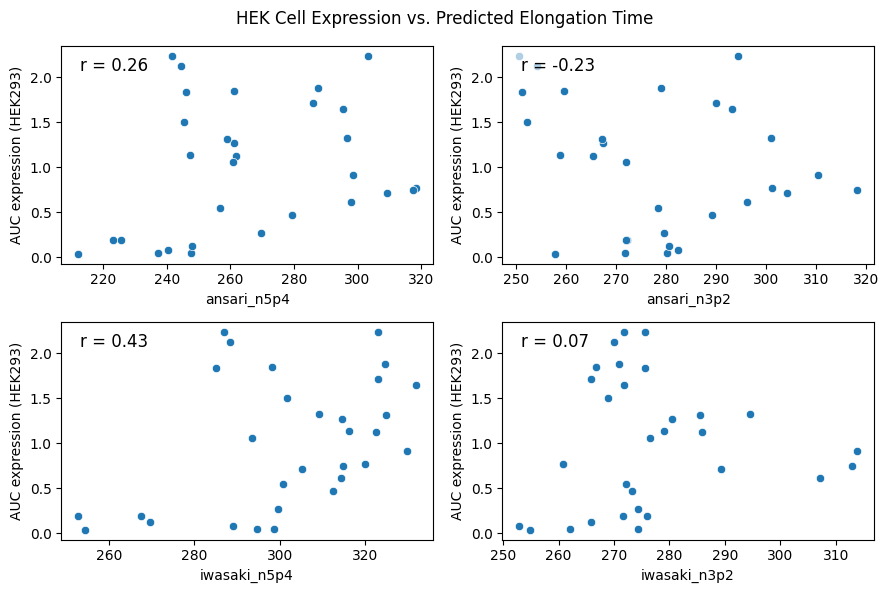

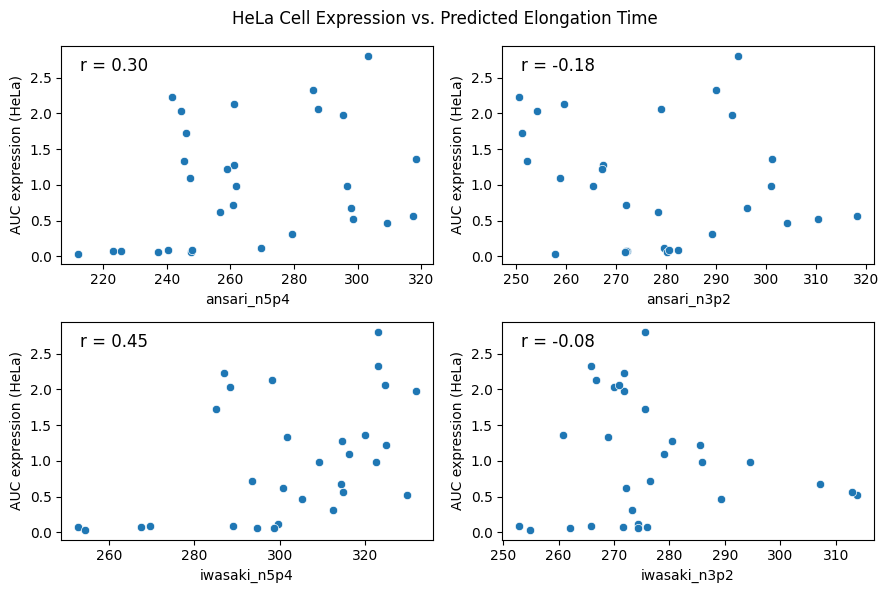

In [25]:
def scatter(df, x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(
        df,
        x = x,
        y = y, 
        # hue = "sequence class",
        ax=ax
    )
    r = df[x].corr(df[y], method="pearson")
    # ax.legend(title="sequence class", **legend_kwargs())
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
    return ax

def superplot(y, title=None):
    fig, axs = plt.subplots(2, 2, figsize=(9, 6))
    scatter(df, "ansari_n5p4", y, ax=axs[0, 0])
    scatter(df, "ansari_n3p2", y, ax=axs[0, 1])
    scatter(df, "iwasaki_n5p4", y, ax=axs[1, 0])
    scatter(df, "iwasaki_n3p2", y, ax=axs[1, 1])
    if title is not None:
        fig.suptitle(title)
    fig.tight_layout()
    plt.show()

superplot("AUC expression (HEK293)", "HEK Cell Expression vs. Predicted Elongation Time")
superplot("AUC expression (HeLa)", "HeLa Cell Expression vs. Predicted Elongation Time")
# superplot("Mean ribosome load (HEK293)")
# superplot("Mean ribosome load (HeLa)")


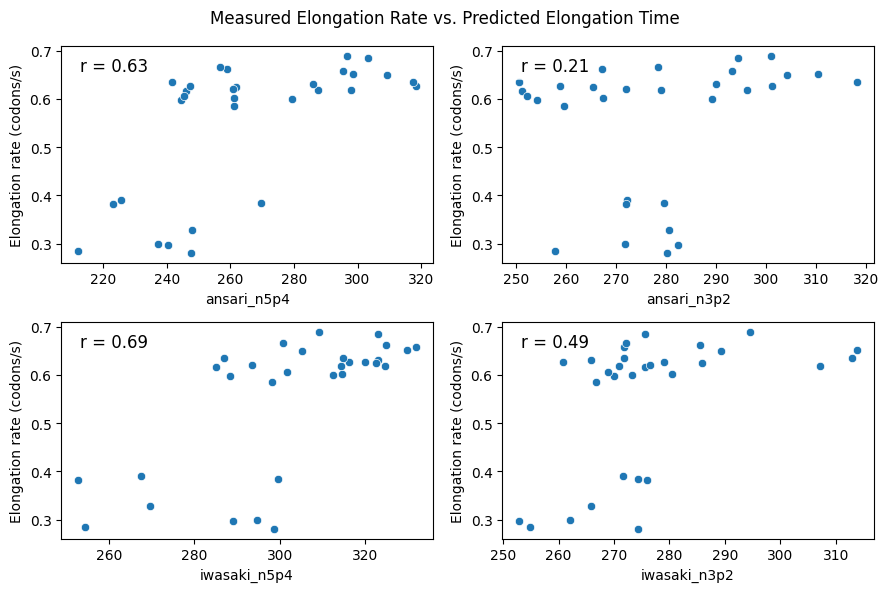

In [30]:
superplot("Elongation rate (codons/s)", "Measured Elongation Rate vs. Predicted Elongation Time")

In [18]:
sahim_seqs = [
    "ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTGTTGAATTGGATGGTGATGTGAATGGTCATAAGTTTAGTGTTAGTGGTGAGGGTGAGGGGGACGCGACGTATGGTAAGTTGACTCTTAAGTTTATTTGTACCACCGGTAAATTGCCCGTGCCATGGCCCACGCTGGTGACGACGCTGGGTTATGGTTTGATGTGTTTTGCACGTTACCCCGACCATATGAAGCAGCATGATTTTTTTAAGAGTGCGATGCCAGAGGGTTACGTGCAGGAGCGGACGATTTTTTTTAAGGATGATGGTAATTATAAAACCCGGGCGGAGGTGAAGTTTGAGGGTGATACGTTGGTGAATAGGATTGAGTTGAAGGGGATTGATTTTAAGGAGGATGGTAATATATTGGGTCATAAGTTAGAGTATAATTATAATAGCCATAATGTATATATTATGGCTGATAAACAAAAGAATGGTATTAAGGTGAATTTTAAGATTAGGCATAATATTGAGGATGGTTCGGTCCAGCTGGCGGATCATTATCAACAAAATACCCCAATTGGTGATGGTCCTGTATTGCTCCCCGATAATCATTATTTGTCGTATCAGTCGGCGCTGTCGAAGGACCCCAATGAGAAGAGGGACCATATGGTGCTGCTGGAGTTTGTGACGGCGGCGGGGATCACGCATGGGATGGATGAGTTGTATAAATGA",
    "ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTGTGGAACTAGACGGGGACGTGAACGGTCACAAGTTTAGTGTCAGCGGAGAAGGTGAAGGTGATGCCACATACGGTAAATTGACCTTGAAATTTATTTGTACTACTGGCAAACTCCCTGTTCCCTGGCCCACACTCGTTACCACGTTAGGTTACGGTCTCATGTGCTTCGCGCGGTACCCAGATCATATGAAGCAGCATGACTTTTTTAAGAGTGCTATGCCCGAGGGTTACGTTCAGGAGCGCACCATATTTTTCAAAGATGATGGAAATTATAAGACCCGCGCAGAGGTAAAATTTGAAGGCGACACACTCGTCAATCGTATTGAGCTCAAAGGTATTGACTTTAAAGAAGACGGCAATATACTAGGCCATAAGCTTGAATATAATTATAATAGTCACAACGTCTACATCATGGCCGATAAGCAGAAGAATGGGATAAAGGTAAACTTCAAAATTCGTCACAACATCGAGGATGGATCTGTACAACTTGCTGACCATTACCAGCAGAACACACCGATAGGTGATGGTCCCGTCTTATTGCCCGACAATCATTATCTGAGCTATCAGTCGGCCCTGTCGAAAGACCCAAACGAGAAACGGGATCATATGGTCCTTCTGGAGTTTGTGACAGCGGCTGGCATAACCCATGGCATGGATGAGTTGTATAAATGA",
    "ATGTCCAAAGGTGAAGAGTTGTTCACTGGGGTGGTACCCATCCTCGTCGAATTAGATGGCGACGTAAATGGTCATAAATTTTCGGTCAGTGGGGAGGGGGAAGGCGATGCAACTTACGGAAAGCTGACTTTAAAATTCATCTGCACAACAGGTAAACTGCCTGTCCCATGGCCAACCCTAGTGACCACCCTCGGTTATGGCTTGATGTGCTTCGCGCGGTATCCTGATCACATGAAACAGCACGACTTCTTTAAGTCCGCCATGCCGGAAGGTTATGTACAAGAACGCACTATTTTCTTTAAGGATGATGGAAACTATAAAACCAGAGCGGAGGTTAAATTCGAGGGGGATACCCTTGTGAACCGCATAGAGCTGAAAGGCATCGACTTTAAGGAGGATGGAAATATACTTGGACACAAGTTGGAGTATAATTACAATTCTCACAACGTCTACATCATGGCGGATAAACAGAAGAATGGGATTAAGGTGAACTTCAAAATTCGTCATAATATAGAAGATGGGTCAGTGCAACTAGCTGACCATTATCAGCAAAACACGCCGATCGGTGATGGACCTGTGTTACTTCCTGATAATCATTACCTGTCATATCAGTCTGCACTAAGCAAGGACCCAAACGAAAAAAGGGACCACATGGTGCTTTTAGAGTTCGTCACTGCGGCGGGGATCACGCACGGGATGGATGAACTTTATAAATGA",
    "ATGTCTAAGGGCGAAGAGCTATTTACGGGGGTTGTACCTATCCTAGTCGAACTTGACGGGGACGTGAATGGTCATAAATTTAGCGTATCTGGCGAGGGGGAGGGAGACGCAACGTACGGAAAGTTGACACTAAAATTCATCTGTACAACCGGCAAACTACCAGTCCCATGGCCCACACTAGTAACCACTTTAGGGTACGGACTAATGTGTTTCGCTAGGTATCCAGACCACATGAAGCAACATGACTTTTTCAAATCTGCTATGCCTGAAGGTTATGTCCAAGAACGAACGATTTTTTTCAAAGACGATGGAAACTACAAAACCAGAGCGGAGGTGAAATTCGAGGGAGATACTCTGGTTAACCGGATTGAGTTAAAAGGGATTGATTTTAAAGAGGACGGCAATATTTTGGGTCATAAACTAGAATACAACTATAATAGCCATAACGTGTATATAATGGCCGACAAACAGAAAAATGGTATAAAAGTAAACTTCAAAATTCGTCATAACATTGAAGATGGAAGTGTGCAGCTTGCGGATCACTATCAACAAAACACACCGATTGGCGACGGGCCGGTTCTACTACCGGACAATCATTATCTAAGCTATCAGAGTGCTCTATCCAAGGATCCTAATGAGAAGCGGGACCATATGGTCCTACTGGAGTTCGTTACGGCAGCTGGGATCACACATGGTATGGATGAGCTTTACAAATGA",
    "ATGAGTAAGGGGGAGGAGTTGTTTACTGGAGTCGTTCCTATTCTGGTGGAGTTAGACGGAGACGTCAATGGACATAAATTCTCAGTTTCCGGCGAAGGGGAAGGAGATGCAACCTACGGGAAGCTTACTCTAAAGTTCATATGCACAACTGGCAAGCTTCCGGTGCCATGGCCTACTTTAGTAACGACCCTGGGGTACGGATTGATGTGTTTCGCAAGGTATCCCGATCATATGAAACAGCACGACTTCTTTAAATCTGCCATGCCCGAAGGGTACGTTCAAGAGAGGACAATATTTTTCAAGGATGACGGAAATTACAAAACCCGTGCAGAAGTGAAGTTCGAAGGCGATACATTAGTTAACAGGATAGAACTGAAAGGGATCGATTTCAAAGAAGACGGTAATATTCTTGGACATAAGCTAGAATACAACTATAACAGTCACAATGTCTACATCATGGCGGACAAGCAGAAAAACGGCATCAAGGTAAATTTCAAAATACGGCACAACATCGAAGACGGATCAGTACAGCTGGCAGACCACTACCAGCAAAACACACCTATTGGCGATGGCCCTGTTTTACTTCCGGACAACCACTATTTATCCTACCAGTCCGCGTTGTCGAAAGATCCTAACGAAAAGCGAGATCATATGGTTTTGTTGGAATTTGTAACTGCTGCTGGAATTACACATGGTATGGACGAATTATATAAATGA",
    "ATGAGCAAAGGAGAAGAGTTATTCACAGGCGTCGTTCCGATACTAGTCGAACTAGACGGAGACGTCAACGGACACAAATTCTCAGTATCCGGAGAAGGAGAAGGAGACGCTACCTACGGGAAACTTACGCTAAAATTCATATGCACAACGGGGAAACTACCTGTCCCGTGGCCTACTCTAGTCACAACCCTAGGATACGGACTAATGTGCTTCGCTCGATACCCGGATCACATGAAACAACACGACTTCTTCAAATCGGCCATGCCCGAAGGATATGTCCAAGAAAGGACAATATTCTTCAAAGACGACGGAAACTACAAAACGCGAGCAGAGGTCAAATTCGAAGGAGACACGTTAGTCAACAGAATCGAACTGAAAGGCATAGACTTCAAGGAAGACGGAAACATCCTAGGACACAAACTGGAATACAATTACAATTCTCACAACGTGTACATAATGGCAGACAAACAGAAAAACGGAATAAAAGTCAACTTCAAGATACGACACAACATAGAAGACGGATCTGTTCAGCTAGCAGACCACTACCAGCAGAACACACCAATTGGAGACGGACCAGTTCTGCTTCCCGACAACCACTATCTATCTTACCAGAGCGCTCTATCCAAAGATCCTAACGAAAAGCGAGATCACATGGTCCTACTAGAATTCGTAACAGCAGCAGGCATAACACACGGAATGGACGAACTTTACAAATGA",
]
scores = [132.595560933, 212.500182193, 247.345849672, 255.400404295, 293.12011958, 393.606701321]
ansari_n5p4_scores = [predict_elongation(i, ansari_n5p4) for i in sahim_seqs]
iwasaki_n5p4_scores = [predict_elongation(i, iwasaki_n5p4) for i in sahim_seqs]
ansari_n3p2_scores = [predict_elongation(i, ansari_n3p2, min_cod=-3, max_cod=2) for i in sahim_seqs]
iwasaki_n3p2_scores = [predict_elongation(i, iwasaki_n3p2, min_cod=-3, max_cod=2) for i in sahim_seqs]

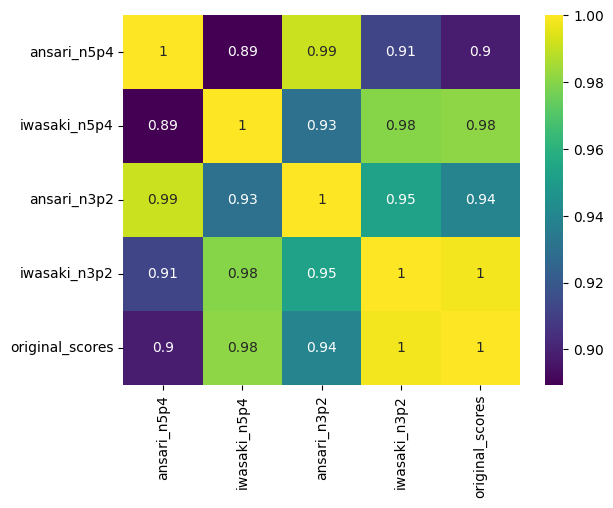

In [29]:
citrine_df = pd.DataFrame({
    "ansari_n5p4" : ansari_n5p4_scores,
    "iwasaki_n5p4" : iwasaki_n5p4_scores,
    "ansari_n3p2" : ansari_n3p2_scores,
    "iwasaki_n3p2" : iwasaki_n3p2_scores,
    "original_scores" : scores,
})
sns.heatmap(
    citrine_df.corr(method="pearson"),
    annot=True, cmap="viridis"
    )
plt.yticks(rotation=0)
plt.show()